# Deriving Potentials from Atomistic Data

Deriving bead-bead interaction parameters using atomistic target data follows an identical procedure to that used in the previous tutorial.

First, to provide an idea of what an atomistic nanoparticle looks like, we'll use the `AA_nano` class to carve one from bulk silica with a radius of 4nm.

In [1]:
from nanoparticle_optimization import AA_nano

aa_nano = AA_nano(radius=4)
aa_nano.visualize()

/Users/summeraz/src/github/mosdef-hub/mbuild/mbuild/compound.py:2183: UserWarning: Guessing that "<SI pos=( 4.8542, 4.3209, 1.8580), 0 bonds, id: 112271327184>" is element: "S"
  atom, element))


NGLWidget()

Now, we'll load target data that has been collected for the interaction potential between two of these nanoparticles with radii of 4nm. All target data is included within the NanoOpt repository.

Text(0,0.5,'U, kcal/mol')

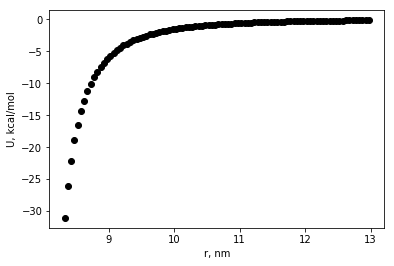

In [3]:
import pkg_resources

import numpy as np

import nanoparticle_optimization
from nanoparticle_optimization.target import load

resource_package = nanoparticle_optimization.__name__
resource_path = '/'.join(('utils', 'target_data', 'np_np', 'truncated', 'U_4nm_truncated.txt'))
target_4nm = load(pkg_resources.resource_filename(resource_package, resource_path))

target_4nm.separations /= 10.0

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(target_4nm.separations, target_4nm.potential, linestyle='None', marker='o', color='black')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

Let's also go ahead and load the target data for a nanoparticle with a radius of 6nm.

Text(0,0.5,'U, kcal/mol')

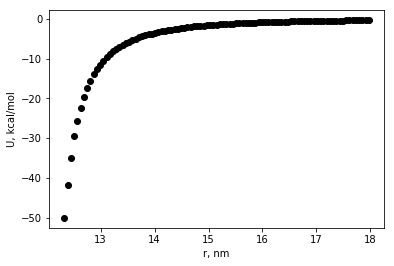

In [4]:
import pkg_resources

import numpy as np

import nanoparticle_optimization
from nanoparticle_optimization.target import load

resource_package = nanoparticle_optimization.__name__
resource_path = '/'.join(('utils', 'target_data', 'np_np', 'truncated', 'U_6nm_truncated.txt'))
target_6nm = load(pkg_resources.resource_filename(resource_package, resource_path))

target_6nm.separations /= 10.0

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(target_6nm.separations, target_6nm.potential, linestyle='None', marker='o', color='black')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

Now we'll construct the coarse-grained analogs. First, we'll build the CG nanoparticle with a radius of 4nm (we'll use a bead diameter of 0.8nm and a volume fraction of 0.5).

In [9]:
from nanoparticle_optimization import CG_nano

cgnano_4nm = CG_nano(radius=4.0, bead_diameter=0.8, bvf=0.5)
cgnano_4nm.visualize()

/Users/summeraz/src/github/mosdef-hub/mbuild/mbuild/compound.py:2183: UserWarning: Guessing that "<_CGN pos=( 0.3257, 0.0000,-3.7876), 0 bonds, id: 112217734336>" is element: "EP"
  atom, element))


NGLWidget()

And we'll do the same for a nanoparticle with a radius of 6nm.

In [10]:
cgnano_6nm = CG_nano(radius=6.0, bead_diameter=0.8, bvf=0.5)

Now let's create our two `system`s featuring these nanoparticles, along with the force field (in Mie functional form) that we want to optimize the parameters of. We'll fix the values of `sigma` at 0.8nm as this defines the diameter of the pseudo-atoms.  Since the Mie potential features degeneracy, we will also fix the value of the repulsive exponent, $n$ to 35. So our optimization will only involve epsilon and $m$.

In [11]:
from nanoparticle_optimization.forcefield import Mie, Parameter
from nanoparticle_optimization.system import System

sigma = Parameter(value=0.8, fixed=True)
epsilon = Parameter(value=6.0, upper=20.0, lower=0.1)
n = Parameter(value=35.0, fixed=True)
m = Parameter(value=5.0, upper=20.0, lower=3.0)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

system_4nm = System(cgnano_4nm)
system_6nm = System(cgnano_6nm)

Now, let's perform the first stage of the three-stage optimization, where we will perform a brute-force optimization over a coarse parameter grid. Note: This will take several minutes to run.

In [12]:
from nanoparticle_optimization.optimization import Optimization

optimization = Optimization(forcefield=ff, systems=[system_4nm, system_6nm], targets=[target_4nm, target_6nm],
                                   configurations=10)
optimization.optimize(brute_force=True, gridpoints=8, verbose=False,
                      r_dependent_sampling=True, maxiter=50, polishing_function=None)

Now, we'll use the results from the first stage to define bounds for our second brute-force optimization over a finer grid.

In [13]:
grid_residuals = optimization.grid_residuals
epsilon_vals = optimization.grid[0]
m_vals = optimization.grid[1]
minimum = np.array(np.unravel_index(grid_residuals.argmin(), grid_residuals.shape))
epsilon_at_min = epsilon_vals[minimum[0]][0]
m_at_min = m_vals[0][minimum[1]]

# Set new bounds
try:
    emax = epsilon_vals[tuple(minimum + np.array([2, 0]))]
except IndexError:
    emax = epsilon_vals[-1, 0]
if minimum[0] - 2 >= 0:
    emin = epsilon_vals[tuple(minimum + np.array([-2, 0]))]
else:
    emin = epsilon_vals[0, 0]
    
try:
    mmax = m_vals[tuple(minimum + np.array([0, 2]))]
except IndexError:
    mmax = m_vals[0, -1]
if minimum[1] - 2 >= 0:
    mmin = m_vals[tuple(minimum + np.array([0, -2]))]
else:
    mmin = m_vals[0, 0]

print('epsilon-max: {:.3f},\tepsilon-min: {:.3f}'.format(emax, emin))
print('m-max: {:.3f},\tm-min: {:.3f}'.format(mmax, mmin))

epsilon-max: 8.629,	epsilon-min: 0.100
m-max: 10.286,	m-min: 3.000


Now we'll perform the final two stages of the optimization, the second brute-force stage and the polishing stage.

In [14]:
sigma = Parameter(value=0.8, fixed=True)
epsilon = Parameter(value=6.0, upper=emax, lower=emin)
n = Parameter(value=35.0, fixed=True)
m = Parameter(value=5.0, upper=mmax, lower=mmin)
ff = Mie(sigma=sigma, epsilon=epsilon, n=n, m=m)

cgnano_4nm = CG_nano(radius=4.0, bead_diameter=0.8, bvf=0.5)
cgnano_6nm = CG_nano(radius=6.0, bead_diameter=0.8, bvf=0.5)
system_4nm = System(cgnano_4nm)
system_6nm = System(cgnano_6nm)
optimization = Optimization(forcefield=ff, systems=[system_4nm, system_6nm], targets=[target_4nm, target_6nm],
                                   configurations=10)
optimization.optimize(brute_force=True, gridpoints=8, verbose=False,
                      r_dependent_sampling=True, maxiter=50)

Let's see how well we did. First, we'll compare the interaction potential for the nanoparticle with a radius of 4nm.

Text(0,0.5,'U, kcal/mol')

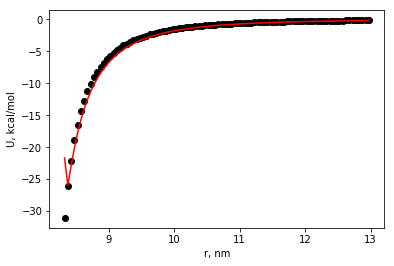

In [12]:
U_opt_4nm, _ = zip(*system_4nm.calc_potential(forcefield=optimization.forcefield, separations=target_4nm.separations))

plt.plot(target_4nm.separations, target_4nm.potential, linestyle='None', marker='o', color='black')
plt.plot(target_4nm.separations, U_opt_4nm, marker='None', color='red')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

We get an interaction potential that matches the all-atom result closely. You'll notice that we don't have any data in the repulsive regime for the all-atom data, and that the CG interaction potential well does not quite match up. This is due to the hard-core nature of the nanoparticle-nanoparticle interaction that features a sharp and abrupt increase in this regime where data collection is difficult. Fortunately, in practice nanoparticles will feature a coating and so the regime of short-separations is not our primary concern. Instead, we are focused on reproducing the longer range behavior, which the plot above shows is captured nicely.

Finally, let's make sure we also capture the interaction potential of the nanoparticle with a radius of 6nm.

Text(0,0.5,'U, kcal/mol')

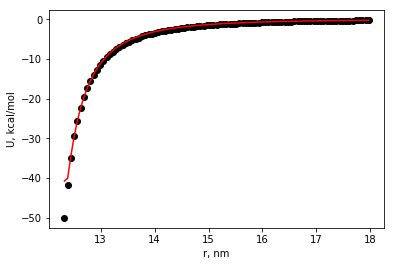

In [15]:
U_opt_6nm, _ = zip(*system_6nm.calc_potential(forcefield=optimization.forcefield, separations=target_6nm.separations))

plt.plot(target_6nm.separations, target_6nm.potential, linestyle='None', marker='o', color='black')
plt.plot(target_6nm.separations, U_opt_6nm, marker='None', color='red')
plt.xlabel('r, nm')
plt.ylabel('U, kcal/mol')

Again, we see good agreement, showing that we have found bead-bead interaction parameters that are tranferable to multiple nanoparticle sizes.